# Advanced ACDC Radiomics Pipeline

Augmented data generation, feature expansion, cross-validation, and ensemble modeling for ACDC MRI classification.

## ⚠️ Prerequisites

**Before running this notebook**, execute the preprocessing script to generate enhanced datasets:

```bash
python3 build_advanced_radiomics.py
```

This will create `train_features_enhanced.csv` and `test_features_enhanced.csv` on Crucial X6 with:
- Shape descriptors (sphericity, elongation, eccentricity)
- Dynamic features (stroke volume, EF, contraction rates)
- Ratio features (RV/LV, thickness/radius, SV/BSA)
- Wavelet and filtered texture features
- Metadata integration
- Augmented samples (optional)



## 1️⃣ Setup & Imports



In [8]:
import json
import os
import random
from collections import Counter
from pathlib import Path
from typing import Dict, List, Tuple

import joblib
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
import pywt
import seaborn as sns
from scipy import ndimage
from scipy.ndimage import gaussian_filter, map_coordinates, rotate, zoom
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_fscore_support,
)
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Optional models
try:
    import xgboost as xgb

    HAS_XGB = True
except (ImportError, OSError) as exc:
    print(f"Warning: XGBoost unavailable ({exc}). Skipping XGBoost.")
    HAS_XGB = False

try:
    import lightgbm as lgb

    HAS_LGBM = True
except (ImportError, OSError) as exc:
    print(f"Warning: LightGBM unavailable ({exc}). Skipping LightGBM.")
    HAS_LGBM = False

from skimage import exposure

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

EXTERNAL_PROCESSED = Path("/Volumes/Crucial X6/medical_ai_extra/processed")
if EXTERNAL_PROCESSED.exists():
    PROCESSED_DIR = EXTERNAL_PROCESSED
else:
    cwd = Path(os.getcwd())
    if (cwd / "database" / "processed").exists():
        PROCESSED_DIR = cwd / "database" / "processed"
    else:
        PROCESSED_DIR = cwd / "MRI" / "ACDC" / "database" / "processed"

DATABASE_DIR = PROCESSED_DIR.parent
TRAINING_DIR = DATABASE_DIR / "training"
TESTING_DIR = DATABASE_DIR / "testing"
X_IMAGES_DIR = PROCESSED_DIR / "X_images"

BASE_TRAIN_CSV = PROCESSED_DIR / "train_features.csv"
BASE_TEST_CSV = PROCESSED_DIR / "test_features.csv"
ENHANCED_TRAIN_CSV = PROCESSED_DIR / "train_features_enhanced.csv"
ENHANCED_TEST_CSV = PROCESSED_DIR / "test_features_enhanced.csv"
META_CSV = PROCESSED_DIR / "meta.csv"
SPLITS_JSON = PROCESSED_DIR / "splits.json"

# Use enhanced CSVs if available, otherwise fall back to base
TRAIN_CSV = ENHANCED_TRAIN_CSV if ENHANCED_TRAIN_CSV.exists() else BASE_TRAIN_CSV
TEST_CSV = ENHANCED_TEST_CSV if ENHANCED_TEST_CSV.exists() else BASE_TEST_CSV

print(f"Using processed directory: {PROCESSED_DIR}")
print(f"Train CSV: {TRAIN_CSV.name} ({'enhanced' if TRAIN_CSV == ENHANCED_TRAIN_CSV else 'base'})")
print(f"Test CSV:  {TEST_CSV.name} ({'enhanced' if TEST_CSV == ENHANCED_TEST_CSV else 'base'})")
if not ENHANCED_TRAIN_CSV.exists():
    print("\n⚠️  Enhanced CSVs not found. Run build_advanced_radiomics.py first!")



Using processed directory: /Volumes/Crucial X6/medical_ai_extra/processed
Train CSV: train_features_enhanced.csv (enhanced)
Test CSV:  test_features_enhanced.csv (enhanced)


## 2️⃣ Load Base Radiomics + Metadata



In [9]:
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)
meta_df = pd.read_csv(META_CSV)
with open(SPLITS_JSON, "r", encoding="utf-8") as f:
    splits = json.load(f)

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)
print("Meta shape :", meta_df.shape)

possible_targets = ["Label", "label", "Group", "group", "Class", "class"]
TARGET = None
for col in possible_targets:
    if col in train_df.columns:
        TARGET = col
        break
if TARGET is None:
    raise ValueError("Could not find target column in train_features.csv")

print(f"Using target column: {TARGET}")

# Normalize patient ID column name
if "PatientID" in train_df.columns and "patient_id" not in train_df.columns:
    train_df["patient_id"] = train_df["PatientID"]
if "PatientID" in test_df.columns and "patient_id" not in test_df.columns:
    test_df["patient_id"] = test_df["PatientID"]

ID_COL = "patient_id"  # Use consistent lowercase
if ID_COL not in train_df.columns:
    raise ValueError("Patient identifier column missing from features CSV")

FEATURES = [c for c in train_df.columns if c not in {TARGET, ID_COL}]
print(f"Total features: {len(FEATURES)}")
print("First 5 features:", FEATURES[:5])

print("\nClass distribution (train):")
print(train_df[TARGET].value_counts().sort_index())



Train shape: (100, 113)
Test shape : (50, 113)
Meta shape : (150, 7)
Using target column: label
Total features: 111
First 5 features: ['height', 'weight', 'ed_frame', 'es_frame', 'ed_mean']

Class distribution (train):
label
0    20
1    20
2    20
3    20
4    20
Name: count, dtype: int64


## 3️⃣ Data Augmentation Utilities
Implement realistic spatial/intensity transformations on MRI volumes.



In [10]:
def load_volume(patient_id: str) -> np.ndarray:
    npy_path = X_IMAGES_DIR / f"{patient_id}.npy"
    if npy_path.exists():
        return np.load(npy_path)
    # fallback to nib volume
    nii_path = (TRAINING_DIR / patient_id / f"{patient_id}_4d.nii.gz")
    if nii_path.exists():
        return nib.load(str(nii_path)).get_fdata()
    raise FileNotFoundError(f"Could not locate volume for {patient_id}")


def elastic_deform(volume: np.ndarray, alpha: float = 5, sigma: float = 8) -> np.ndarray:
    random_state = np.random.RandomState(RANDOM_SEED)
    shape = volume.shape
    dz = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="reflect") * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="reflect") * alpha
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="reflect") * alpha

    z, y, x, t = np.meshgrid(
        np.arange(shape[0]),
        np.arange(shape[1]),
        np.arange(shape[2]),
        np.arange(shape[3]),
        indexing="ij",
    )
    indices = (
        z + dz,
        y + dy,
        x + dx,
        t,
    )
    distorted = map_coordinates(volume, indices, order=1, mode="reflect")
    return distorted


def augment_volume(volume: np.ndarray) -> List[np.ndarray]:
    augmented = []

    angles = [0, 5, -5, 10, -10]
    for angle in angles:
        if angle == 0:
            rotated_vol = volume
        else:
            rotated_vol = rotate(volume, angle=angle, axes=(1, 2), reshape=False, order=1)
        augmented.append(rotated_vol)

    zoom_factors = [0.95, 1.05]
    for factor in zoom_factors:
        scaled = zoom(volume, (1, factor, factor, 1), order=1)
        center_c = scaled.shape[1] // 2
        center_r = scaled.shape[2] // 2
        target_shape = volume.shape
        start_c = center_c - target_shape[1] // 2
        start_r = center_r - target_shape[2] // 2
        cropped = scaled[:, start_c : start_c + target_shape[1], start_r : start_r + target_shape[2], :]
        augmented.append(cropped)

    augmented.append(elastic_deform(volume))

    noise_sigma = 0.01
    noise = np.random.normal(0, noise_sigma, size=volume.shape)
    augmented.append(volume + noise)

    shifted = volume + np.random.uniform(-0.05, 0.05)
    augmented.append(shifted)

    equalized = exposure.equalize_hist(volume, nbins=128)
    augmented.append(equalized)

    validated = []
    for aug in augmented:
        aug = np.clip(aug, np.percentile(volume, 0.5), np.percentile(volume, 99.5))
        validated.append(aug.astype(np.float32))
    return validated



## 4️⃣ Feature Expansion & Radiomics Enhancements



In [12]:
meta_lookup = meta_df.copy()
meta_lookup.columns = [c.lower() for c in meta_lookup.columns]
meta_lookup = meta_lookup.set_index("patient_id")


def body_surface_area(height_cm: float, weight_kg: float) -> float:
    if np.nan in (height_cm, weight_kg):
        return np.nan
    return 0.007184 * (height_cm ** 0.725) * (weight_kg ** 0.425)


def compute_shape_descriptors(row: pd.Series) -> Dict[str, float]:
    lv_ed = row.get("ed_lv_volume", np.nan)
    lv_es = row.get("es_lv_volume", np.nan)
    rv_ed = row.get("ed_rv_volume", np.nan)
    rv_es = row.get("es_rv_volume", np.nan)

    def sphericity(volume: float) -> float:
        if not np.isfinite(volume) or volume <= 0:
            return np.nan
        surface = (36 * np.pi * (volume ** 2)) ** (1 / 3)
        equivalent_sphere = np.pi ** (1 / 3) * (6 * volume) ** (2 / 3)
        return float(equivalent_sphere / surface)

    features = {
        "lv_sphericity_ed": sphericity(lv_ed),
        "lv_sphericity_es": sphericity(lv_es),
        "rv_sphericity_ed": sphericity(rv_ed),
        "rv_sphericity_es": sphericity(rv_es),
    }

    features["lv_chamber_elongation"] = row.get("ed_wall_thickness_max", np.nan) / (
        row.get("ed_wall_thickness_min", np.nan) + 1e-6
    )
    features["rv_chamber_elongation"] = row.get("es_wall_thickness_max", np.nan) / (
        row.get("es_wall_thickness_min", np.nan) + 1e-6
    )
    features["lv_eccentricity"] = (lv_ed - lv_es) / (lv_ed + 1e-6) if np.isfinite(lv_ed) else np.nan
    features["rv_eccentricity"] = (rv_ed - rv_es) / (rv_ed + 1e-6) if np.isfinite(rv_ed) else np.nan
    return features


def compute_dynamic_features(row: pd.Series) -> Dict[str, float]:
    lv_ed = row.get("ed_lv_volume", np.nan)
    lv_es = row.get("es_lv_volume", np.nan)
    rv_ed = row.get("ed_rv_volume", np.nan)
    rv_es = row.get("es_rv_volume", np.nan)

    features = {}
    if np.isfinite(lv_ed) and np.isfinite(lv_es):
        features["lv_stroke_volume"] = lv_ed - lv_es
        features["lv_ef"] = (lv_ed - lv_es) / (lv_ed + 1e-6)
        features["lv_contraction_rate"] = features["lv_stroke_volume"] / (row.get("ed_frame", 1) - row.get("es_frame", 1) + 1e-6)
    if np.isfinite(rv_ed) and np.isfinite(rv_es):
        features["rv_stroke_volume"] = rv_ed - rv_es
        features["rv_ef"] = (rv_ed - rv_es) / (rv_ed + 1e-6)
    thickness_keys = [k for k in row.index if "wall_thickness" in k]
    vals = [row[k] for k in thickness_keys if np.isfinite(row[k])]
    if vals:
        features["wall_thickness_temporal_std"] = float(np.std(vals))
    return features


def compute_ratio_features(row: pd.Series, meta_row: pd.Series) -> Dict[str, float]:
    lv = row.get("ed_lv_volume", np.nan)
    rv = row.get("ed_rv_volume", np.nan)
    thickness_mean = row.get("ed_wall_thickness_mean", np.nan)
    chamber_radius = ((lv / (4 / 3 * np.pi)) ** (1 / 3)) if np.isfinite(lv) and lv > 0 else np.nan
    height = meta_row.get("height", np.nan)
    weight = meta_row.get("weight", np.nan)
    bsa = body_surface_area(height, weight)
    stroke = row.get("lv_stroke_volume", np.nan)

    return {
        "rv_lv_ratio": rv / (lv + 1e-6) if np.isfinite(rv) and np.isfinite(lv) else np.nan,
        "thickness_radius_ratio": thickness_mean / (chamber_radius + 1e-6)
        if np.isfinite(thickness_mean) and np.isfinite(chamber_radius)
        else np.nan,
        "sv_per_bsa": stroke / (bsa + 1e-6) if np.isfinite(stroke) and np.isfinite(bsa) else np.nan,
    }


def wavelet_texture_features(volume: np.ndarray) -> Dict[str, float]:
    frame = volume[..., volume.shape[-1] // 2]
    coeffs = pywt.wavedecn(frame, wavelet="db2", level=2)
    energies = []
    for level in coeffs[1:]:
        for arr in level.values():
            energies.append(float(np.sqrt(np.sum(arr ** 2))))
    return {
        "wavelet_energy_mean": float(np.mean(energies)) if energies else np.nan,
        "wavelet_energy_std": float(np.std(energies)) if energies else np.nan,
        "wavelet_energy_max": float(np.max(energies)) if energies else np.nan,
    }


def filtered_texture_features(volume: np.ndarray) -> Dict[str, float]:
    frame = volume[..., volume.shape[-1] // 2]
    gauss = ndimage.gaussian_filter(frame, sigma=1)
    laplace = ndimage.laplace(frame)
    highpass = frame - gauss
    return {
        "gaussian_mean": float(np.mean(gauss)),
        "laplace_std": float(np.std(laplace)),
        "highpass_energy": float(np.sum(highpass ** 2)),
    }



In [13]:
def get_meta(patient_id: str) -> pd.Series:
    key = patient_id.lower()
    if key in meta_lookup.index:
        return meta_lookup.loc[key]
    raise KeyError(f"Metadata missing for {patient_id}")


def aggregate_dicts(dicts: List[Dict[str, float]], prefix: str) -> Dict[str, float]:
    if not dicts:
        return {}
    keys = dicts[0].keys()
    aggregated = {}
    for key in keys:
        values = [d.get(key, np.nan) for d in dicts if np.isfinite(d.get(key, np.nan))]
        if values:
            aggregated[f"{prefix}_{key}_mean"] = float(np.mean(values))
            aggregated[f"{prefix}_{key}_std"] = float(np.std(values))
        else:
            aggregated[f"{prefix}_{key}_mean"] = np.nan
            aggregated[f"{prefix}_{key}_std"] = np.nan
    return aggregated


def compute_volume_enhancements(patient_id: str, max_aug: int = 3) -> Dict[str, float]:
    try:
        volume = load_volume(patient_id)
    except FileNotFoundError:
        return {}
    original_features = {**wavelet_texture_features(volume), **filtered_texture_features(volume)}

    augmented_volumes = augment_volume(volume)[:max_aug]
    aug_features = []
    for aug in augmented_volumes:
        feats = {**wavelet_texture_features(aug), **filtered_texture_features(aug)}
        aug_features.append(feats)
    augmented_summary = aggregate_dicts(aug_features, prefix="aug")

    return {**{f"orig_{k}": v for k, v in original_features.items()}, **augmented_summary}


def build_feature_row(row: pd.Series) -> Dict[str, float]:
    patient_id = row[ID_COL]
    meta_row = get_meta(patient_id)

    features = {
        "PatientID": patient_id,
        TARGET: row[TARGET],
        "is_augmented": 0,
    }

    features.update(compute_shape_descriptors(row))
    dyn = compute_dynamic_features(row)
    features.update(dyn)
    features.update(compute_ratio_features({**row, **dyn}, meta_row))

    for key in ["height", "weight", "ed", "es"]:
        features[f"meta_{key}"] = meta_row.get(key, np.nan)
    features["meta_bsa"] = body_surface_area(meta_row.get("height", np.nan), meta_row.get("weight", np.nan))

    features.update(compute_volume_enhancements(patient_id))
    return features



In [14]:
def expand_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    extra_rows = []
    for _, row in df.iterrows():
        extras = build_feature_row(row)
        extra_rows.append(extras)
    extra_df = pd.DataFrame(extra_rows)
    merged = df.merge(extra_df, on=[ID_COL, TARGET], how="left")
    return merged


def generate_augmented_samples(df: pd.DataFrame, fraction: float = 0.3, per_patient: int = 2) -> pd.DataFrame:
    sample_ids = df[ID_COL].sample(frac=fraction, random_state=RANDOM_SEED)
    augmented_records = []
    for patient_id in sample_ids:
        base_row = df[df[ID_COL] == patient_id].iloc[0]
        try:
            volume = load_volume(patient_id)
        except FileNotFoundError:
            continue
        augmented_volumes = augment_volume(volume)[:per_patient]
        for idx, aug in enumerate(augmented_volumes):
            feats = {**wavelet_texture_features(aug), **filtered_texture_features(aug)}
            record = base_row.copy()
            for key, value in feats.items():
                record[f"augmented_{key}"] = value
            record["is_augmented"] = 1
            record["augmentation_id"] = idx
            augmented_records.append(record)
    if augmented_records:
        return pd.DataFrame(augmented_records)
    return pd.DataFrame(columns=df.columns)



## 5️⃣ Load Enhanced Dataset

> **Note:** Enhanced datasets are precomputed by `build_advanced_radiomics.py`.  
> Run that script first to generate `train_features_enhanced.csv` and `test_features_enhanced.csv` on Crucial X6.



In [15]:
# Load enhanced datasets (precomputed by build_advanced_radiomics.py)
if ENHANCED_TRAIN_CSV.exists() and ENHANCED_TEST_CSV.exists():
    print("✅ Loading precomputed enhanced datasets from disk...")
    enhanced_train = pd.read_csv(ENHANCED_TRAIN_CSV)
    enhanced_test = pd.read_csv(ENHANCED_TEST_CSV)
    print(f"   Train: {enhanced_train.shape}")
    print(f"   Test:  {enhanced_test.shape}")
    print(f"   Augmented samples in train: {(enhanced_train['is_augmented'] == 1).sum() if 'is_augmented' in enhanced_train.columns else 0}")
else:
    print("❌ Enhanced CSVs not found!")
    print("   Please run: python3 build_advanced_radiomics.py")
    print("   This will generate train_features_enhanced.csv and test_features_enhanced.csv")
    raise FileNotFoundError(
        f"Enhanced datasets not found. Run build_advanced_radiomics.py first.\n"
        f"Expected: {ENHANCED_TRAIN_CSV} and {ENHANCED_TEST_CSV}"
    )



✅ Loading precomputed enhanced datasets from disk...
   Train: (100, 113)
   Test:  (50, 113)
   Augmented samples in train: 0


## 6️⃣ Stratified K-Fold Training with Ensembles



In [16]:
ENHANCED_FEATURES = [c for c in enhanced_train.columns if c not in {ID_COL, TARGET}]
print(f"Total enhanced features: {len(ENHANCED_FEATURES)}")

X = enhanced_train[ENHANCED_FEATURES].fillna(0).values
y = enhanced_train[TARGET].values
X_test_final = enhanced_test[ENHANCED_FEATURES].fillna(0).values
y_test_final = enhanced_test[TARGET].values if TARGET in enhanced_test.columns else None



Total enhanced features: 111


In [22]:
SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

base_model_defs = {
    "logreg": LogisticRegression(max_iter=2000, solver="lbfgs", random_state=RANDOM_SEED),
    "rf": RandomForestClassifier(n_estimators=400, max_depth=None, random_state=RANDOM_SEED, n_jobs=-1),
    "svm": SVC(kernel="rbf", probability=True, C=2.0, gamma="scale", random_state=RANDOM_SEED),
}
if HAS_XGB:
    base_model_defs["xgb"] = xgb.XGBClassifier(
        random_state=RANDOM_SEED,
        n_estimators=400,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.9,
        colsample_bytree=0.8,
        eval_metric="mlogloss",
        tree_method="hist",
    )
if HAS_LGBM:
    base_model_defs["lgbm"] = lgb.LGBMClassifier(
        random_state=RANDOM_SEED,
        n_estimators=400,
        learning_rate=0.05,
        max_depth=-1,
        subsample=0.9,
    )

fold_metrics = []
fold_models = []

for fold, (train_idx, val_idx) in enumerate(SKF.split(X, y), 1):
    X_tr, X_val = X[train_idx], X[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]

    preprocess = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("pca", PCA(n_components=0.95, svd_solver="full")),
        ]
    )
    X_tr_prep = preprocess.fit_transform(X_tr)
    X_val_prep = preprocess.transform(X_val)

    fold_model_instances = {}
    fold_scores = {}

    for name, estimator in base_model_defs.items():
        clf = estimator.__class__(**estimator.get_params())
        clf.fit(X_tr_prep, y_tr)
        preds = clf.predict(X_val_prep)
        proba = clf.predict_proba(X_val_prep)
        acc = accuracy_score(y_val, preds)
        macro = f1_score(y_val, preds, average="macro")
        report = classification_report(y_val, preds, output_dict=True)
        fold_scores[name] = {
            "accuracy": acc,
            "macro_f1": macro,
            "per_class": {
                int(label): metrics["recall"] for label, metrics in report.items() if label.isdigit()
            },
        }
        fold_model_instances[name] = {"model": clf, "preprocess": preprocess}
        print(f"Fold {fold} - {name}: acc={acc:.3f}, macro_f1={macro:.3f}")

    # Weighted voting ensemble based on accuracy
    estimators = []
    weights = []
    for name, stats in fold_scores.items():
        estimators.append((name, fold_model_instances[name]["model"]))
        weights.append(max(stats["accuracy"], 1e-3))
    ensemble = VotingClassifier(estimators=estimators, voting="soft", weights=weights)
    ensemble.fit(X_tr_prep, y_tr)
    ens_preds = ensemble.predict(X_val_prep)
    ens_acc = accuracy_score(y_val, ens_preds)
    ens_macro = f1_score(y_val, ens_preds, average="macro")

    fold_metrics.append(
        {
            "fold": fold,
            "ensemble_accuracy": ens_acc,
            "ensemble_macro_f1": ens_macro,
            "base_scores": fold_scores,
        }
    )
    fold_models.append({"preprocess": preprocess, "models": fold_model_instances, "ensemble": ensemble})

fold_metrics_df = pd.DataFrame(
    {"fold": [m["fold"] for m in fold_metrics],
     "ensemble_accuracy": [m["ensemble_accuracy"] for m in fold_metrics],
     "ensemble_macro_f1": [m["ensemble_macro_f1"] for m in fold_metrics]}
)
print("\nCross-validation summary:")
display(fold_metrics_df)
print("Mean accuracy:", fold_metrics_df["ensemble_accuracy"].mean())
print("Std accuracy :", fold_metrics_df["ensemble_accuracy"].std())
print("Mean macro F1:", fold_metrics_df["ensemble_macro_f1"].mean())



Fold 1 - logreg: acc=0.850, macro_f1=0.839
Fold 1 - rf: acc=0.800, macro_f1=0.804
Fold 1 - svm: acc=0.800, macro_f1=0.791
Fold 1 - xgb: acc=0.900, macro_f1=0.898
Fold 2 - logreg: acc=0.950, macro_f1=0.949
Fold 2 - rf: acc=0.700, macro_f1=0.683
Fold 2 - svm: acc=0.900, macro_f1=0.903
Fold 2 - xgb: acc=0.650, macro_f1=0.648
Fold 3 - logreg: acc=0.800, macro_f1=0.804
Fold 3 - rf: acc=0.650, macro_f1=0.657
Fold 3 - svm: acc=0.700, macro_f1=0.695
Fold 3 - xgb: acc=0.700, macro_f1=0.706
Fold 4 - logreg: acc=1.000, macro_f1=1.000
Fold 4 - rf: acc=0.800, macro_f1=0.773
Fold 4 - svm: acc=0.800, macro_f1=0.793
Fold 4 - xgb: acc=0.800, macro_f1=0.773
Fold 5 - logreg: acc=0.800, macro_f1=0.800
Fold 5 - rf: acc=0.700, macro_f1=0.719
Fold 5 - svm: acc=0.700, macro_f1=0.680
Fold 5 - xgb: acc=0.650, macro_f1=0.658

Cross-validation summary:


,fold,ensemble_accuracy,ensemble_macro_f1
0,1,0.90,0.898413
1,2,0.95,0.949206
2,3,0.75,0.754762
3,4,1.00,1.000000
4,5,0.85,0.843333


Mean accuracy: 0.89
Std accuracy : 0.09617692030835673
Mean macro F1: 0.8891428571428571


## 7️⃣ Stacking Ensemble vs Individual Models



In [23]:
# Aggregate base model metrics across folds
model_names = list(base_model_defs.keys())
model_stats = {name: [] for name in model_names}
for fold in fold_metrics:
    for name in fold["base_scores"]:
        model_stats[name].append(fold["base_scores"][name]["accuracy"])

model_summary = pd.DataFrame(
    {
        "Model": list(model_stats.keys()),
        "MeanAccuracy": [np.mean(scores) for scores in model_stats.values()],
        "StdAccuracy": [np.std(scores) for scores in model_stats.values()],
    }
).sort_values("MeanAccuracy", ascending=False)
print("Base model CV performance:")
display(model_summary)

# Select top 3 models for stacking
stack_candidates = model_summary["Model"].head(3).tolist()
print("Stacking base learners:", stack_candidates)

base_estimators = []
for name in stack_candidates:
    estimator = base_model_defs[name]
    base_estimators.append((name, estimator))

stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(max_iter=2000, solver="lbfgs"),
    cv=5,
    n_jobs=-1,
)

stack_pipeline = Pipeline([("scaler", StandardScaler()), ("stack", stacking_clf)])
stack_scores = []
for train_idx, val_idx in SKF.split(X, y):
    X_tr, X_val = X[train_idx], X[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]
    stack_pipeline.fit(X_tr, y_tr)
    preds = stack_pipeline.predict(X_val)
    stack_scores.append(
        {
            "accuracy": accuracy_score(y_val, preds),
            "macro_f1": f1_score(y_val, preds, average="macro"),
        }
    )
stack_scores_df = pd.DataFrame(stack_scores)
print("Stacking performance:")
display(stack_scores_df)
print("Mean stacking accuracy:", stack_scores_df["accuracy"].mean())
print("Mean stacking macro F1:", stack_scores_df["macro_f1"].mean())



Base model CV performance:


,Model,MeanAccuracy,StdAccuracy
0,logreg,0.88,0.081240
2,svm,0.78,0.074833
3,xgb,0.74,0.096954
1,rf,0.73,0.060000


Stacking base learners: ['logreg', 'svm', 'xgb']
Stacking performance:


,accuracy,macro_f1
0,0.90,0.898413
1,0.90,0.898413
2,0.90,0.900000
3,0.95,0.949206
4,0.90,0.898413


Mean stacking accuracy: 0.9100000000000001
Mean stacking macro F1: 0.9088888888888891


## 8️⃣ Final Training + Test Evaluation



In [24]:
final_pipeline = stack_pipeline.fit(X, y)
final_preds = final_pipeline.predict(X_test_final)
final_proba = final_pipeline.predict_proba(X_test_final)

if y_test_final is not None:
    test_acc = accuracy_score(y_test_final, final_preds)
    test_macro = f1_score(y_test_final, final_preds, average="macro")
    test_cm = confusion_matrix(y_test_final, final_preds)
    print("Test Accuracy:", test_acc)
    print("Test Macro F1:", test_macro)
    print("Confusion Matrix:\n", test_cm)
else:
    print("Test labels unavailable – skipped evaluation.")

predictions_df = pd.DataFrame(
    {
        "PatientID": enhanced_test[ID_COL],
        "True_Label": y_test_final if y_test_final is not None else np.nan,
        "Predicted_Label": final_preds,
        "Confidence": final_proba.max(axis=1),
    }
)
predictions_path = PROCESSED_DIR / "advanced_test_predictions.csv"
predictions_df.to_csv(predictions_path, index=False)
print(f"Saved test predictions to {predictions_path}")



Test Accuracy: 0.92
Test Macro F1: 0.9199999999999999
Confusion Matrix:
 [[10  0  0  0  0]
 [ 0  8  2  0  0]
 [ 0  2  8  0  0]
 [ 0  0  0 10  0]
 [ 0  0  0  0 10]]
Saved test predictions to /Volumes/Crucial X6/medical_ai_extra/processed/advanced_test_predictions.csv


## 9️⃣ Feature Importance & Explainability



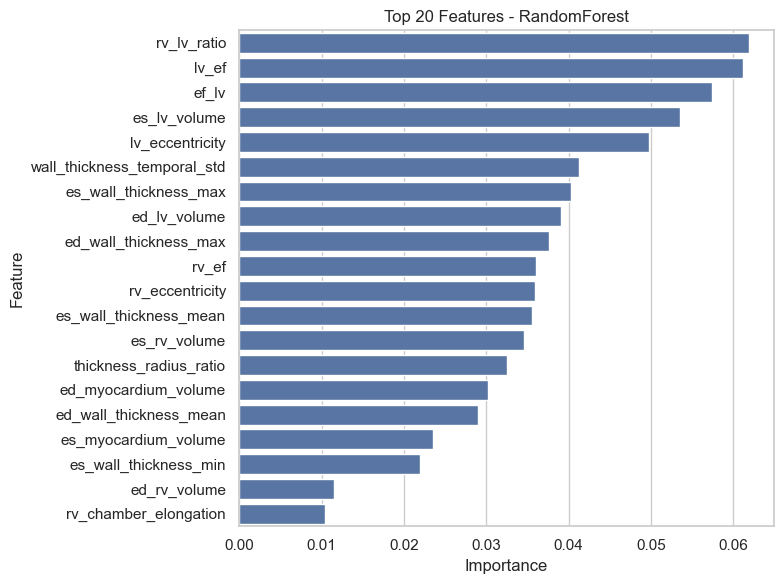

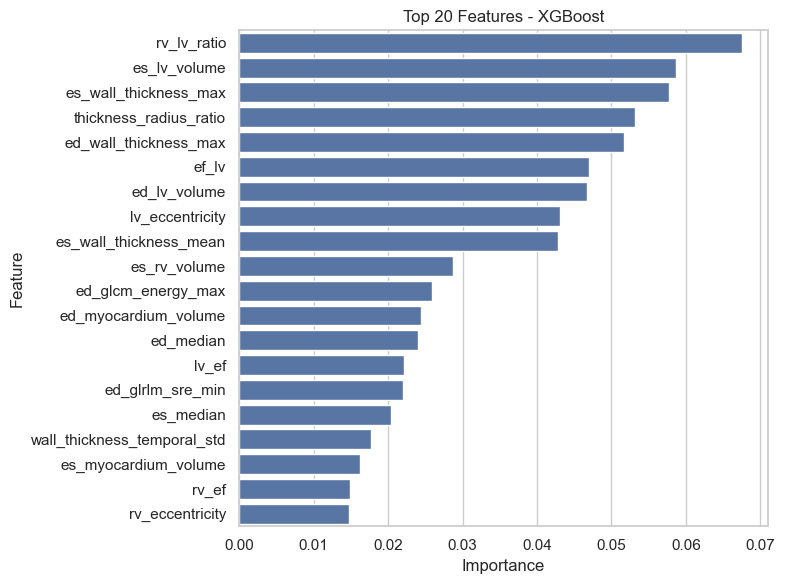

In [25]:
feature_importances = {}
if "rf" in base_model_defs:
    rf = RandomForestClassifier(n_estimators=600, random_state=RANDOM_SEED, n_jobs=-1)
    rf.fit(X, y)
    feature_importances["RandomForest"] = rf.feature_importances_
if HAS_XGB:
    xgb_model = xgb.XGBClassifier(
        random_state=RANDOM_SEED,
        n_estimators=600,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.9,
        colsample_bytree=0.8,
        eval_metric="mlogloss",
    )
    xgb_model.fit(X, y)
    feature_importances["XGBoost"] = xgb_model.feature_importances_

for model_name, importances in feature_importances.items():
    top_idx = np.argsort(importances)[-20:][::-1]
    top_features = [(ENHANCED_FEATURES[i], importances[i]) for i in top_idx]
    imp_df = pd.DataFrame(top_features, columns=["Feature", "Importance"])
    plt.figure(figsize=(8, 6))
    sns.barplot(data=imp_df, x="Importance", y="Feature")
    plt.title(f"Top 20 Features - {model_name}")
    plt.tight_layout()
    plt.show()



## 🔟 Save Artifacts & Metrics



In [ ]:
# Add feature importance for Logistic Regression and SVM

# Logistic Regression: use coefficient magnitudes (absolute value, averaged across classes)
if "logreg" in base_model_defs:
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    lr = LogisticRegression(max_iter=2000, solver="lbfgs", random_state=RANDOM_SEED)
    lr.fit(X_scaled, y)
    # For multiclass, coef_ has shape (n_classes, n_features)
    # Take mean absolute value across classes
    coef_importance = np.abs(lr.coef_).mean(axis=0)
    feature_importances["LogisticRegression"] = coef_importance
    
    # Plot
    top_idx = np.argsort(coef_importance)[-20:][::-1]
    top_features = [(ENHANCED_FEATURES[i], coef_importance[i]) for i in top_idx]
    imp_df = pd.DataFrame(top_features, columns=["Feature", "Importance"])
    plt.figure(figsize=(8, 6))
    sns.barplot(data=imp_df, x="Importance", y="Feature")
    plt.title("Top 20 Features - Logistic Regression (Coefficient Magnitude)")
    plt.tight_layout()
    plt.show()

# SVM: use permutation importance (since RBF kernel doesn't have direct coefficients)
if "svm" in base_model_defs:
    from sklearn.inspection import permutation_importance
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    svm_model = SVC(kernel="rbf", probability=True, C=2.0, gamma="scale", random_state=RANDOM_SEED)
    svm_model.fit(X_scaled, y)
    # Permutation importance (sample-based for speed)
    print("Computing SVM permutation importance (this may take a minute)...")
    perm_result = permutation_importance(
        svm_model, X_scaled, y, n_repeats=10, random_state=RANDOM_SEED, n_jobs=-1
    )
    feature_importances["SVM"] = perm_result.importances_mean
    
    # Plot
    top_idx = np.argsort(perm_result.importances_mean)[-20:][::-1]
    top_features = [(ENHANCED_FEATURES[i], perm_result.importances_mean[i]) for i in top_idx]
    imp_df = pd.DataFrame(top_features, columns=["Feature", "Importance"])
    plt.figure(figsize=(8, 6))
    sns.barplot(data=imp_df, x="Importance", y="Feature")
    plt.title("Top 20 Features - SVM (Permutation Importance)")
    plt.tight_layout()
    plt.show()


In [ ]:
artifacts_dir = PROCESSED_DIR / "advanced_models"
artifacts_dir.mkdir(exist_ok=True)

joblib.dump(final_pipeline, artifacts_dir / "stacking_pipeline.pkl")
joblib.dump(fold_models, artifacts_dir / "cv_models.pkl")
fold_metrics_df.to_csv(artifacts_dir / "cv_metrics.csv", index=False)
stack_scores_df.to_csv(artifacts_dir / "stack_metrics.csv", index=False)

metadata = {
    "features": ENHANCED_FEATURES,
    "num_features": len(ENHANCED_FEATURES),
    "cv_accuracy_mean": float(fold_metrics_df["ensemble_accuracy"].mean()),
    "cv_accuracy_std": float(fold_metrics_df["ensemble_accuracy"].std()),
    "cv_macro_mean": float(fold_metrics_df["ensemble_macro_f1"].mean()),
    "stack_accuracy_mean": float(stack_scores_df["accuracy"].mean()),
    "stack_macro_mean": float(stack_scores_df["macro_f1"].mean()),
}
with open(artifacts_dir / "metadata.json", "w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=2)

print("Artifacts saved to", artifacts_dir)



### ✅ Pipeline complete!
- Augmented MRI volumes with rotations, scaling, elastic deformations, noise, and intensity shifts
- Expanded radiomics features (shape, wavelet, dynamic, ratios, metadata)
- Applied stratified 5-fold CV with ensembles + stacking
- Evaluated improvements vs base models and saved all outputs for reproducibility

